In [187]:
import numpy as np
import sklearn.gaussian_process.kernels as kernels
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.kernel_ridge import KernelRidge as KRR
from sklearn.model_selection import GridSearchCV
import scipy.linalg


C:\Users\theob\AppData\Local\Temp\ipykernel_12408\1604828475.py:4: RuntimeWarning: overflow encountered in exp
  frequency=lambda x:1+3*(1/(1+np.exp(-(x+s)/l))-1/(1+np.exp(-(x-s)/l)))


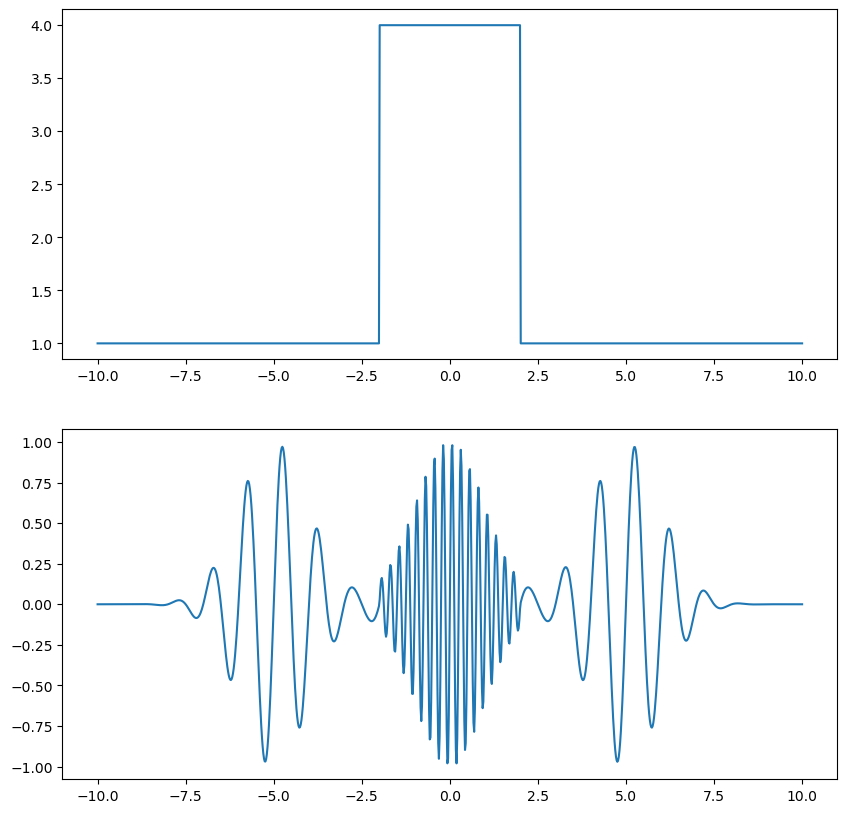

In [188]:
s=2
l=1e-5
L=1
frequency=lambda x:1+3*(1/(1+np.exp(-(x+s)/l))-1/(1+np.exp(-(x-s)/l)))
Y=lambda x:(np.exp(-x**2/2/L**2)+np.exp(-(x-5)**2/2/L**2)+np.exp(-(x+5)**2/2/L**2))*np.sin(2*np.pi*frequency(x)*x)
X=np.linspace(-10,10,1000)
#plot 2 graphs side-by-side (on on top, other one below). One frequency, the other Y
fig,ax=plt.subplots(2,1,figsize=(10,10))
ax[0].plot(X,frequency(X))
ax[1].plot(X,Y(X))
plt.show()


C:\Users\theob\AppData\Local\Temp\ipykernel_12408\1604828475.py:4: RuntimeWarning: overflow encountered in exp
  frequency=lambda x:1+3*(1/(1+np.exp(-(x+s)/l))-1/(1+np.exp(-(x-s)/l)))


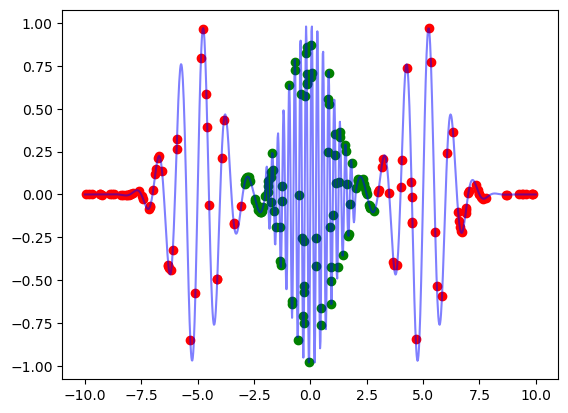

In [189]:
N=200
X_slow=np.concatenate([np.random.uniform(-10,-3,N//4),np.random.uniform(3,10,N//4)])
X_fast=np.random.uniform(-3,3,N//2)
Y_slow=Y(X_slow)
Y_fast=Y(X_fast)
#visualize the data
plt.plot(X,Y(X),color='blue',alpha=0.5)
plt.scatter(X_slow,Y_slow,color='red')
plt.scatter(X_fast,Y_fast,color='green')
plt.show()

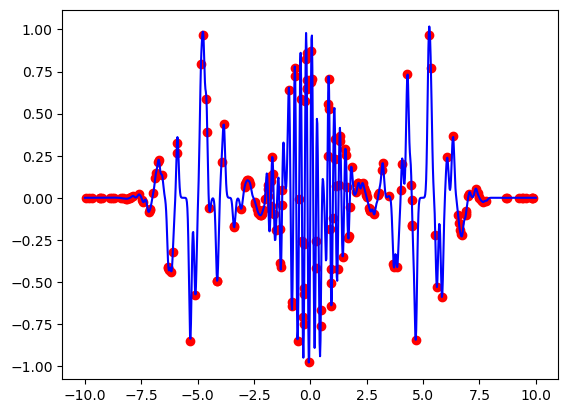

In [206]:
#fit a gaussian process to the data np.concatenate([X_slow,X_fast])
X_train=np.concatenate([X_slow,X_fast]).reshape(-1,1)
Y_train=np.concatenate([Y_slow,Y_fast]).reshape(-1,1)
kernel=kernels.RBF(length_scale_bounds='fixed')#+kernels.WhiteKernel()
gp=KRR(kernel=kernel,alpha=1e-3)
grid = GridSearchCV(estimator=gp, param_grid=dict(kernel__length_scale=np.logspace(-5,1,100)))
grid.fit(X_train, Y_train)
X_test=np.linspace(-10,10,1000).reshape(-1,1)
Y_pred=grid.predict(X_test)
plt.plot(X_test,Y_pred,color='blue')
#plt.fill_between(X_test.flatten(),Y_pred.flatten()-Y_std,Y_pred.flatten()+Y_std,alpha=0.2,color='blue')
plt.scatter(X_train,Y_train,color='red')
plt.show()

In [212]:
k1=kernels.RBF(length_scale=1,length_scale_bounds='fixed')
k2=kernels.RBF(length_scale=1.1e-1,length_scale_bounds='fixed')
#optimize hyperparameters through cross validation
gp_slow=KRR(kernel=k1,alpha=1e-2)
grid_slow = GridSearchCV(estimator=gp_slow, param_grid=dict(kernel__length_scale=np.logspace(-5,1,100)))
grid_slow.fit(X_slow[:,None], Y_slow)
print(grid_slow.best_params_)
gp_fast=KRR(kernel=k2,alpha=1e-1)
grid_fast = GridSearchCV(estimator=gp_fast, param_grid=dict(kernel__length_scale=np.logspace(-5,1,100)))
grid_fast.fit(X_fast[:,None], Y_fast)
print(grid_fast.best_params_)

{'kernel__length_scale': 0.1747528400007683}
{'kernel__length_scale': 0.043287612810830614}


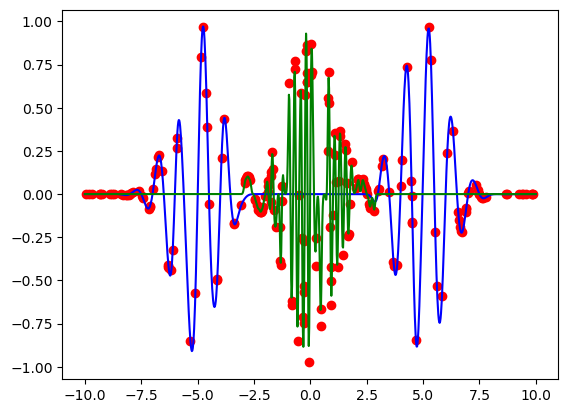

In [213]:

#plot
Y_pred_slow=grid_slow.predict(X_test)
plt.plot(X_test,Y_pred_slow,color='blue')
Y_pred_fast=grid_fast.predict(X_test)
plt.plot(X_test,Y_pred_fast,color='green')
plt.scatter(X_train,Y_train,color='red')
plt.show()

In [214]:
k1=kernels.RBF(length_scale=grid_slow.best_params_['kernel__length_scale'],length_scale_bounds='fixed')
k2=kernels.RBF(length_scale=grid_fast.best_params_['kernel__length_scale'],length_scale_bounds='fixed')
k0=kernels.RBF(length_scale=grid.best_params_['kernel__length_scale'],length_scale_bounds='fixed')
K1=k1(X_slow[:,None],X_slow[:,None])
K2=k2(X_fast[:,None],X_fast[:,None])
K0=k0(X_train,X_train)
inner_dim=max(K1.shape[0],K2.shape[0],K0.shape[0])

In [215]:
L=np.linalg.cholesky(K0+1e-10*np.eye(K0.shape[0]))
L1=np.linalg.cholesky(K1+1e-10*np.eye(K1.shape[0]))
L2=np.linalg.cholesky(K2+1e-10*np.eye(K2.shape[0]))
#add columns of zeros to L1 and L2 to make them have inner_dim columns
L1_pad=np.concatenate([L1,np.zeros((L1.shape[0],inner_dim-L1.shape[1]))],axis=1)
L2_pad=np.concatenate([L2,np.zeros((L2.shape[0],inner_dim-L2.shape[1]))],axis=1)

def L_func(x):
    return scipy.linalg.cho_solve((L,False),k0(X_train,x))


In [217]:
K=L1_pad.T@L1_pad+L2_pad.T@L2_pad
cho_factor=scipy.linalg.cho_factor(K+1e-2*np.eye(K.shape[0]))
alpha=scipy.linalg.cho_solve(cho_factor,L1_pad.T@Y_slow+L2_pad.T@Y_fast)
def pred(x):
    return np.dot(alpha,L_func(x))
pred(X_test[:])

array([-2.88650428e-001, -4.15764313e-001, -5.27634573e-001,
       -5.87388616e-001, -5.68376993e-001, -4.68555299e-001,
       -3.13651678e-001, -1.47539306e-001, -1.62867629e-002,
        4.59160238e-002,  2.49144836e-002, -7.08784420e-002,
       -2.12560677e-001, -3.57907175e-001, -4.63956655e-001,
       -5.01923606e-001, -4.67482408e-001, -3.80115919e-001,
       -2.71639720e-001, -1.71173067e-001, -9.52744768e-002,
       -4.68999124e-002, -2.05553971e-002, -8.65734002e-003,
       -6.04752527e-003, -1.27315784e-002, -3.63892077e-002,
       -9.51024610e-002, -2.17693705e-001, -4.36407924e-001,
       -7.68601026e-001, -1.19329183e+000, -1.63972394e+000,
       -2.00510972e+000, -2.19942993e+000, -2.18950632e+000,
       -2.00962035e+000, -1.73202535e+000, -1.42383014e+000,
       -1.12335183e+000, -8.45166427e-001, -5.97083795e-001,
       -3.89177423e-001, -2.30567094e-001, -1.22772761e-001,
       -5.80272249e-002, -2.30763868e-002, -4.00533701e-003,
        1.14885537e-002,

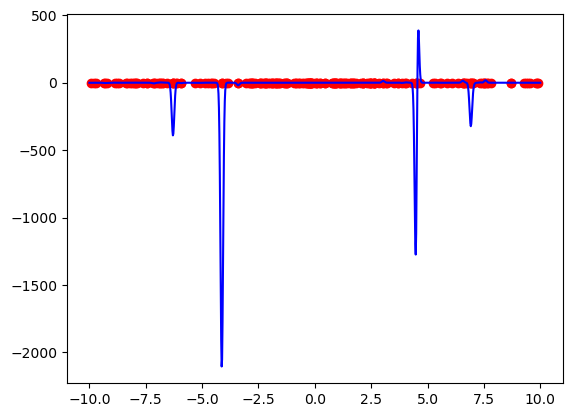

In [218]:
#plot result of prediction
plt.plot(X_test,pred(X_test),color='blue')
plt.scatter(X_train,Y_train,color='red')
plt.show()